## Lead Scoring Case Study
#### by Rohit Nigam and Sayantan De

First we set the width of the notebook. This helps when we are dealing with large dataframes.

In [570]:
from IPython.display import display, HTML
display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
""")) 

Next, we import the libraries necessary at this time. We will import others as the need arises.

In [571]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

We are suppressing all warnings.

In [572]:
# Supress Warnings
import warnings
warnings.filterwarnings('ignore') 

And now we set the our preferred options for the notebook, in reference to the imported libraries.

In [573]:
pd.set_option('display.max_columns', None) 
pd.set_option('display.max_rows', None) 
pd.set_option('display.width', None) 
pd.set_option('display.max_info_columns', 500)
pd.set_option('display.max_info_rows', 500)
sns.set_style(style='darkgrid') 

### Reading the data

We will read the data into pandas and inspect it.

In [574]:
df_leads = pd.read_csv('Leads.csv')
df_leads.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9240 entries, 0 to 9239
Data columns (total 37 columns):
Prospect ID                                      object
Lead Number                                      int64
Lead Origin                                      object
Lead Source                                      object
Do Not Email                                     object
Do Not Call                                      object
Converted                                        int64
TotalVisits                                      float64
Total Time Spent on Website                      int64
Page Views Per Visit                             float64
Last Activity                                    object
Country                                          object
Specialization                                   object
How did you hear about X Education               object
What is your current occupation                  object
What matters most to you in choosing a course    objec

In [575]:
df_leads.shape

(9240, 37)

<Figure size 1800x5040 with 0 Axes>

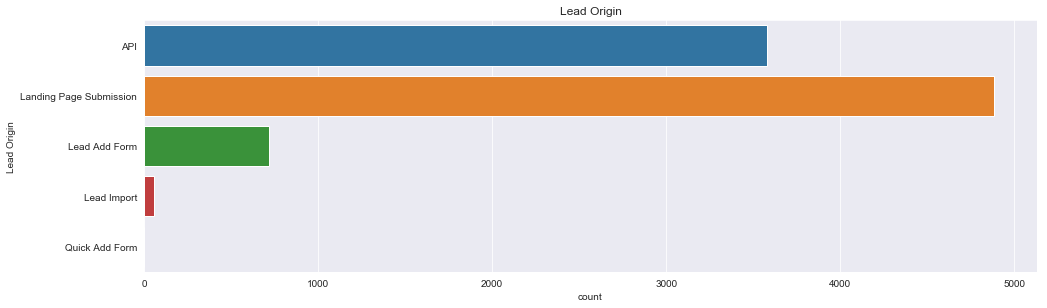

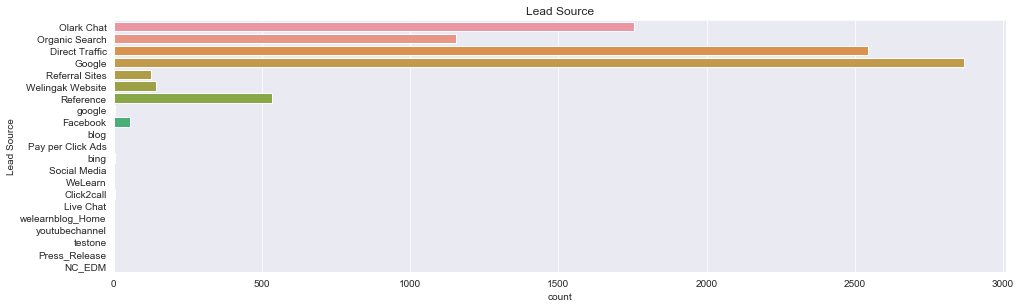

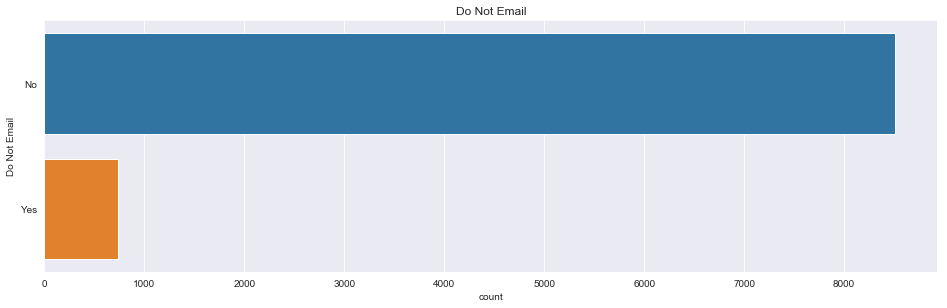

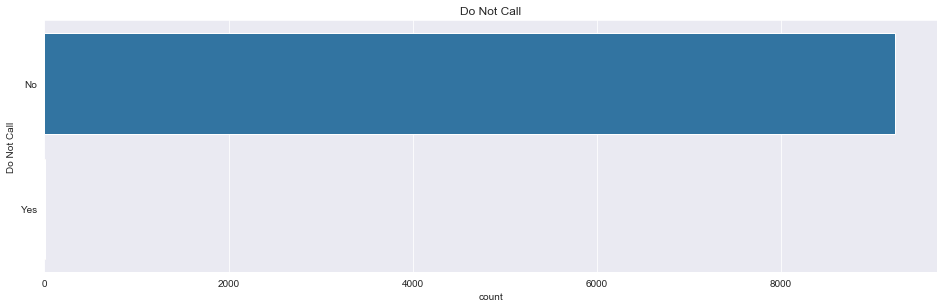

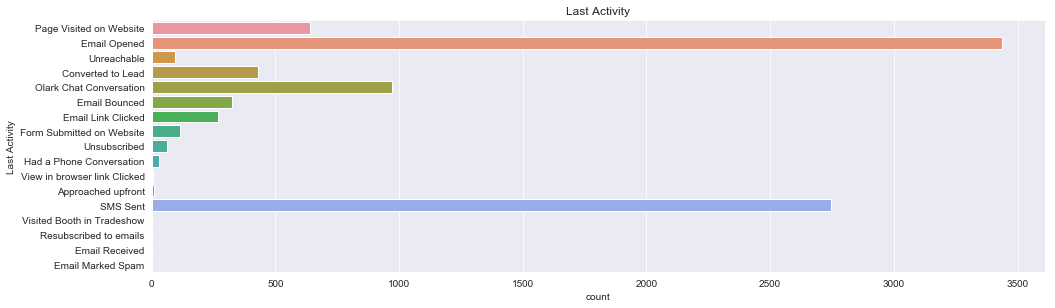

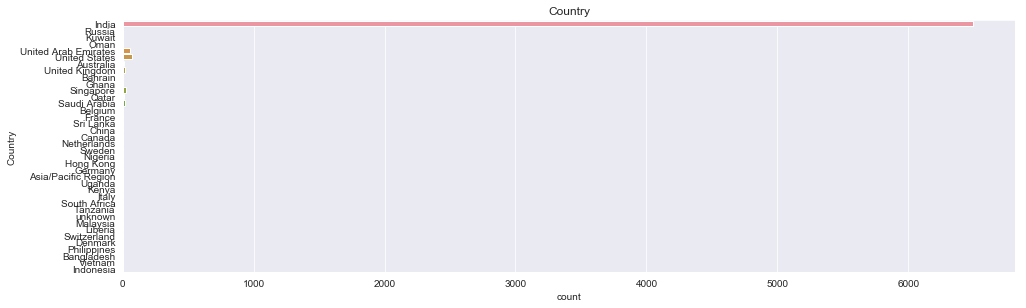

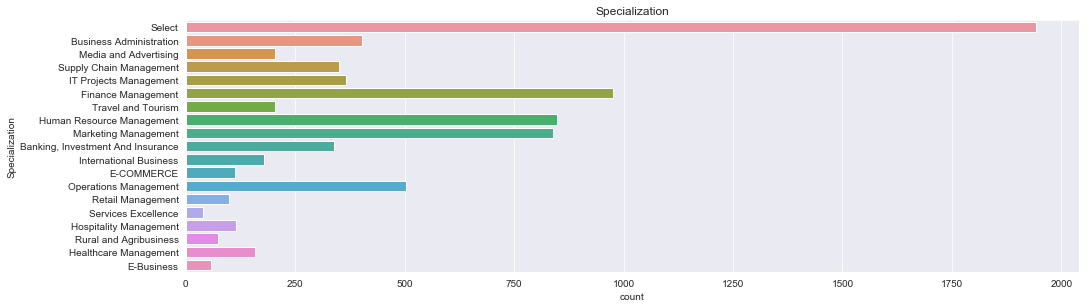

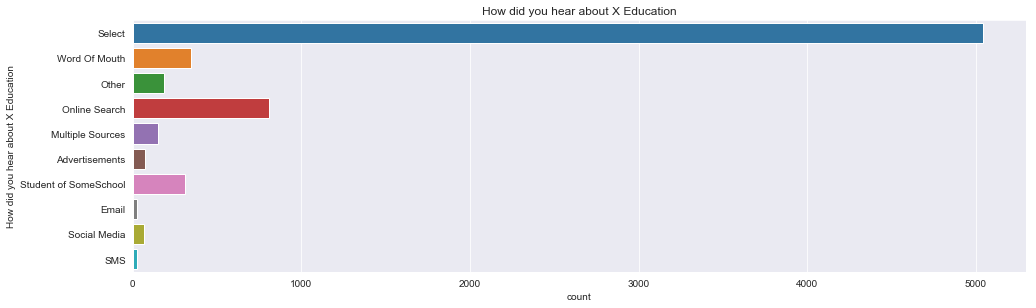

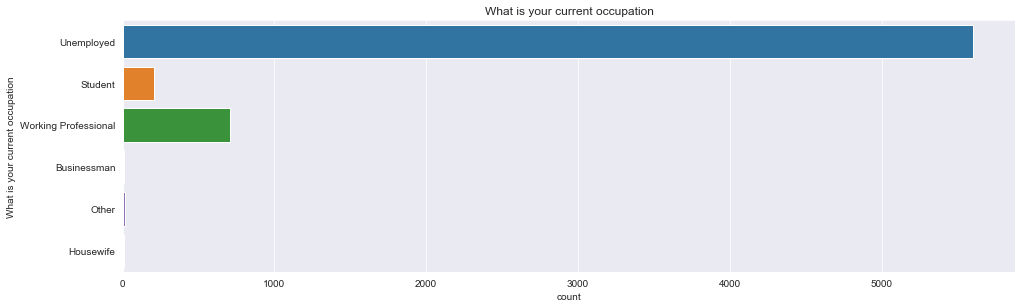

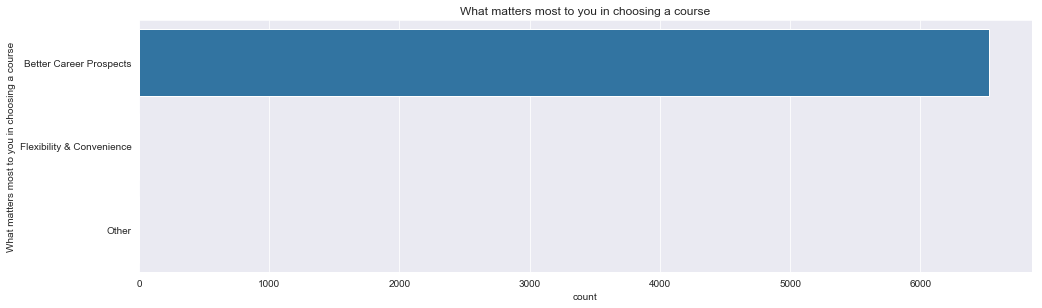

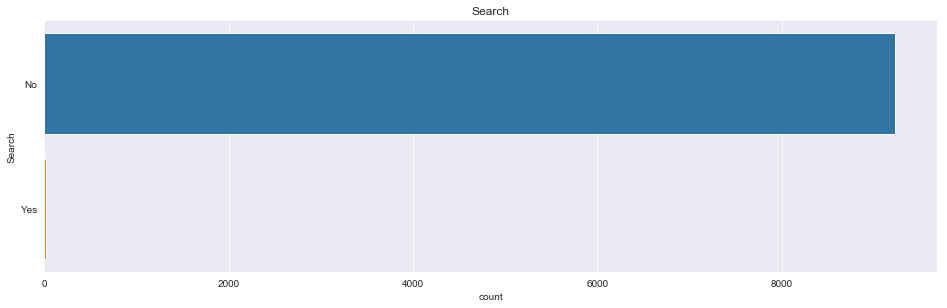

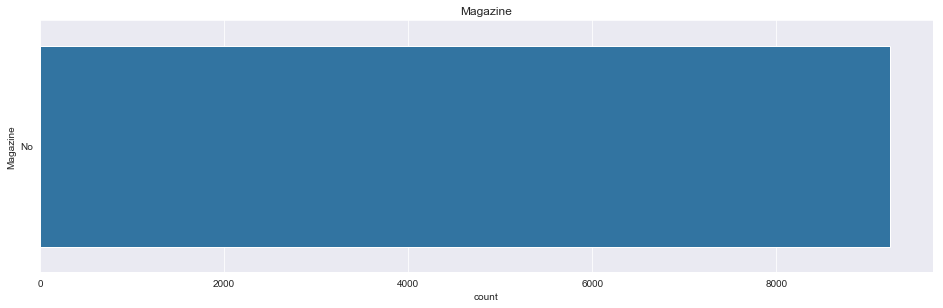

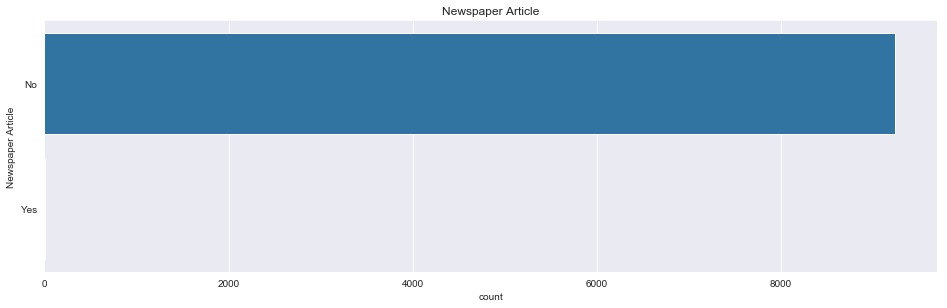

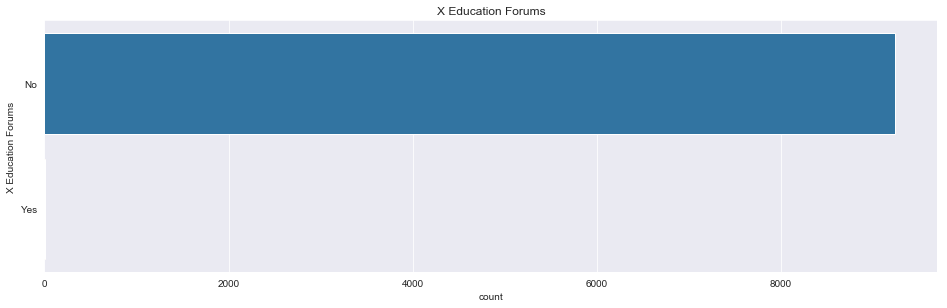

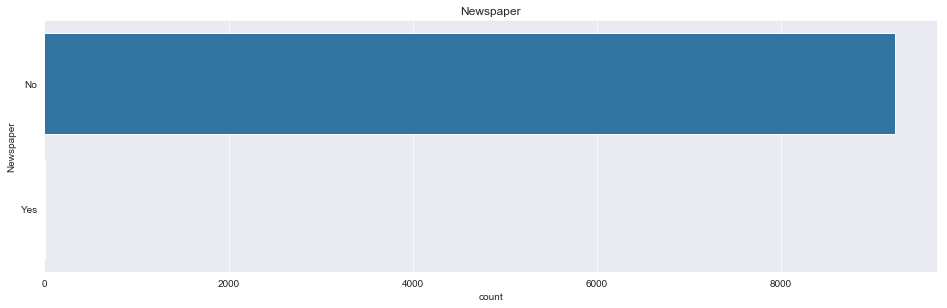

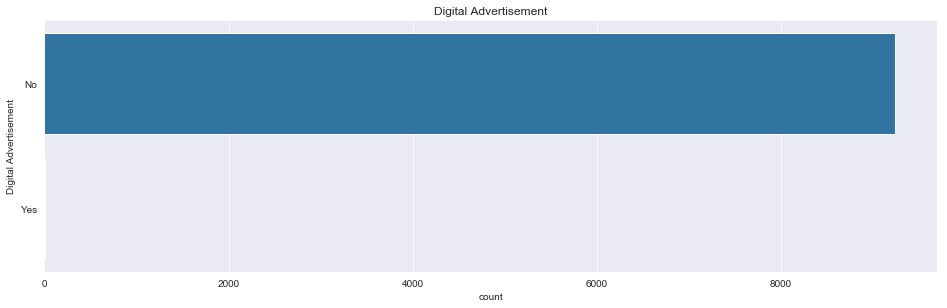

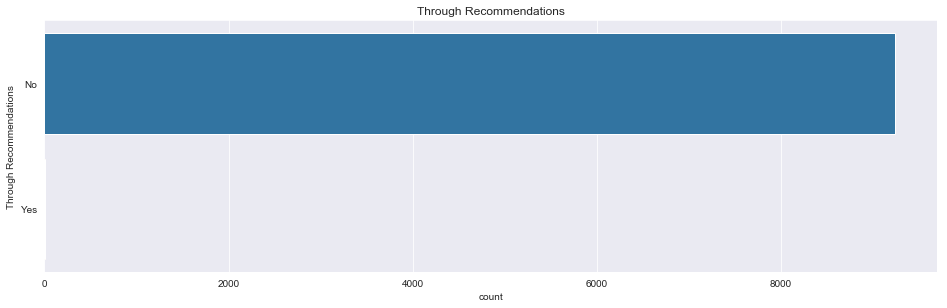

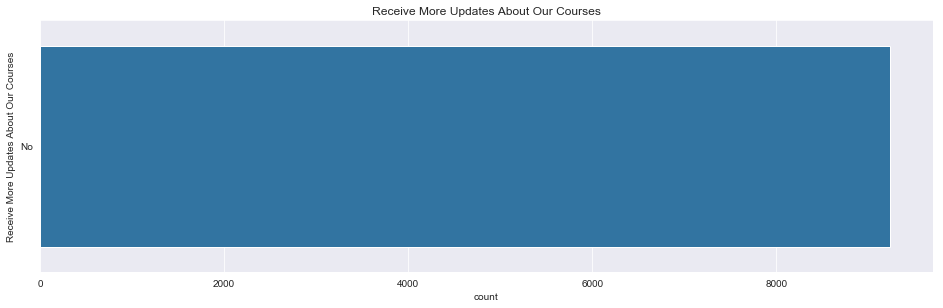

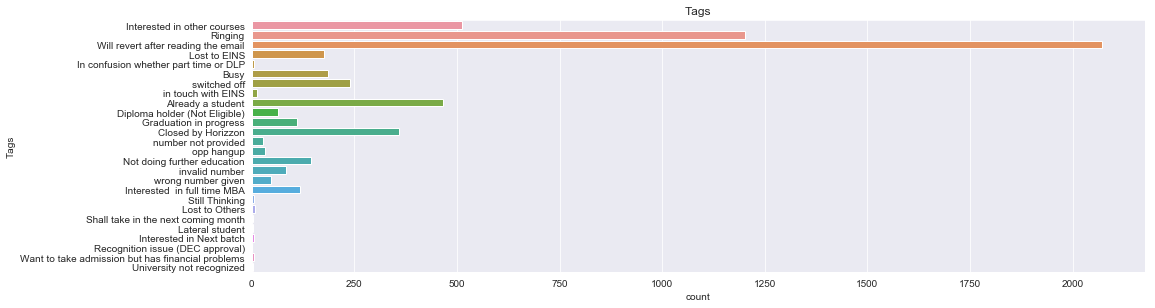

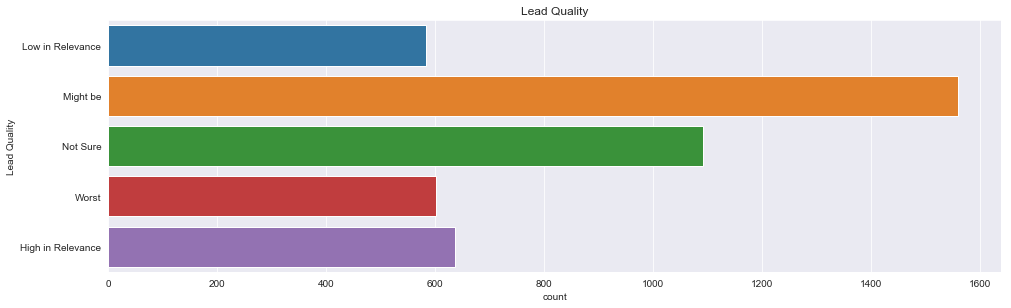

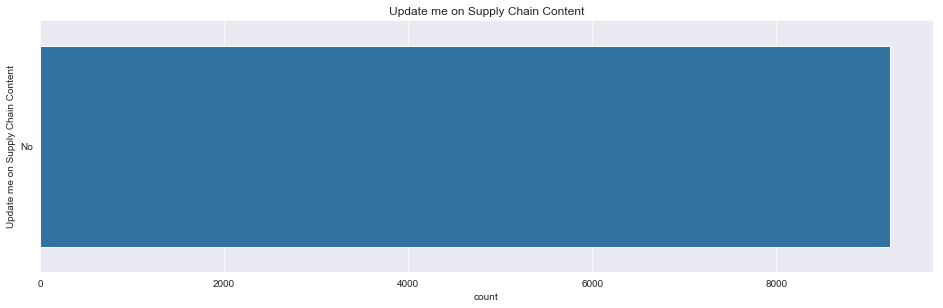

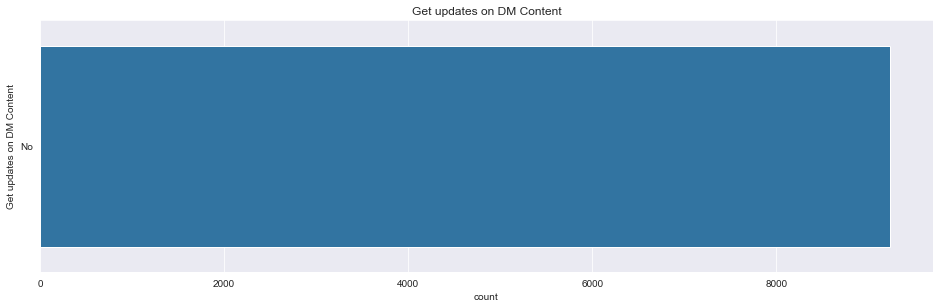

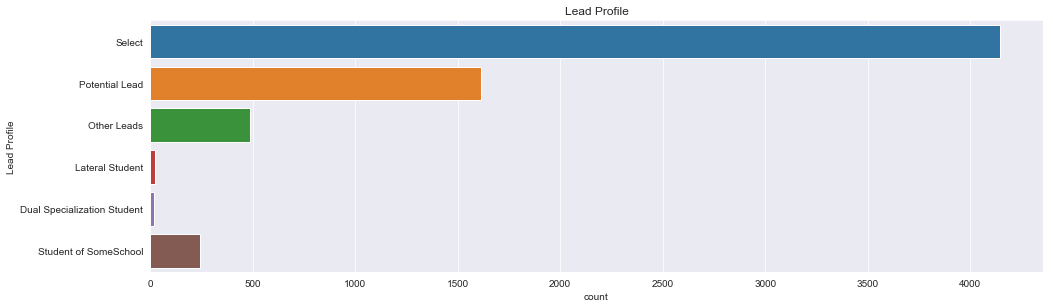

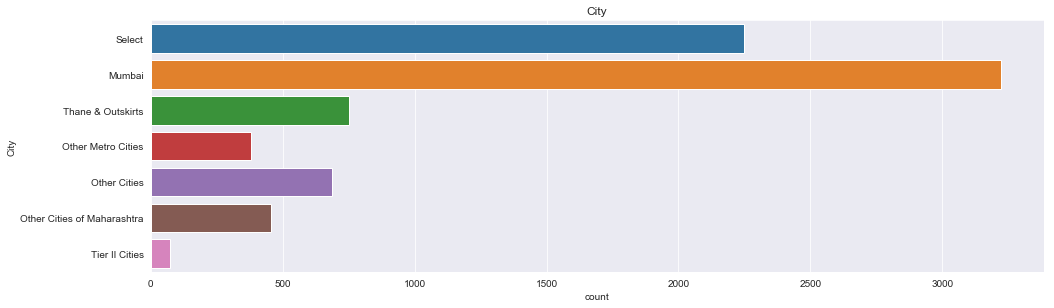

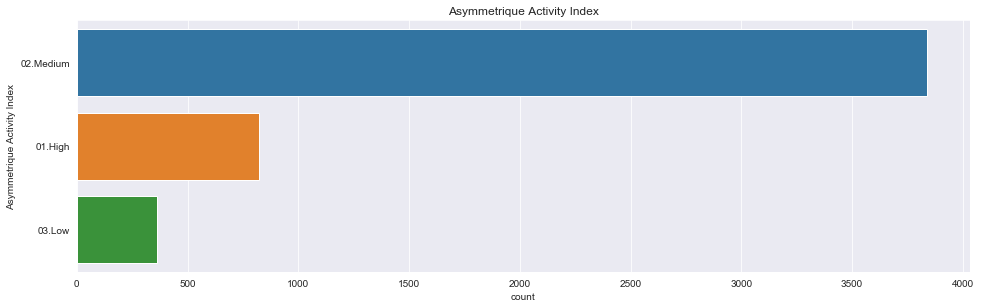

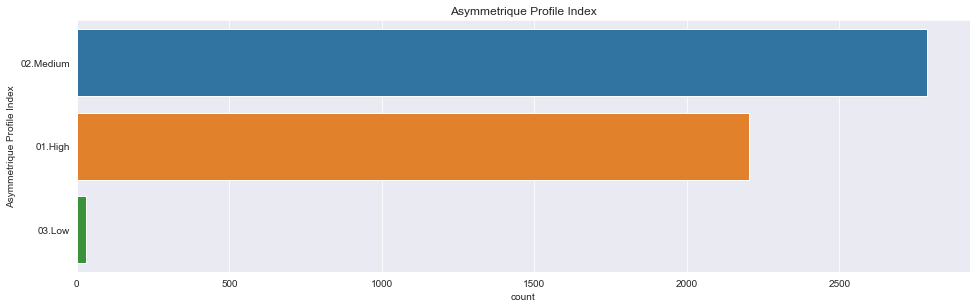

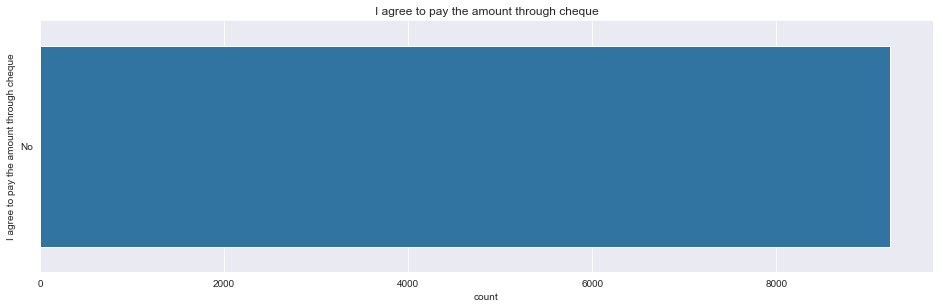

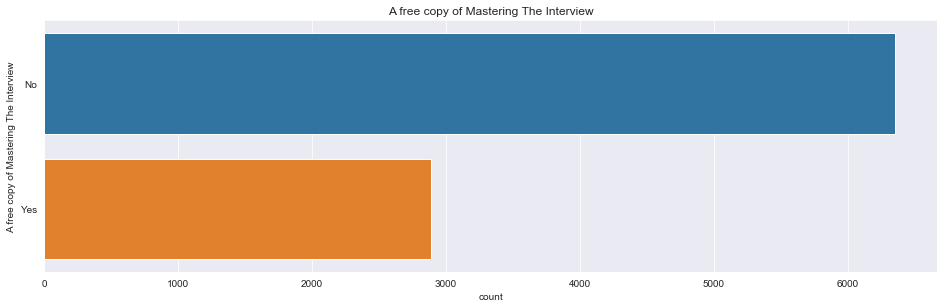

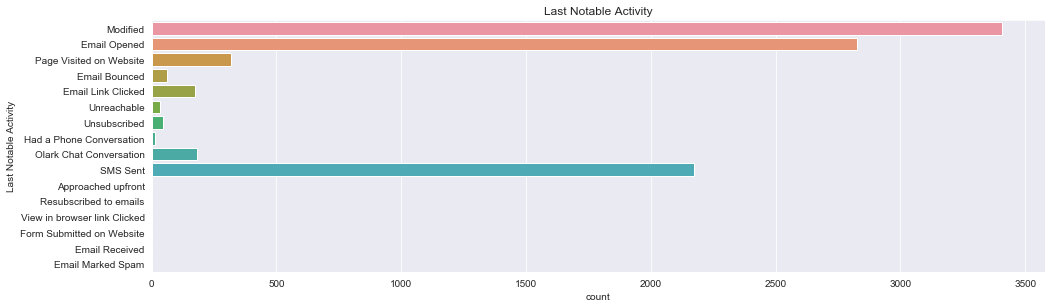

In [576]:
df_obj = df_leads.select_dtypes(object)
col = list(df_obj.columns)[1:]
plt.figure(figsize=[25,70]) 
for i in enumerate(col):
    plt.figure(figsize=[16,160]) 
    plt.subplot(29,1, i[0]+1)
    sns.countplot(y = i[1], data=df_obj) 
    plt.title(i[1])
    plt.show() 

These plots show us what kind of impact each of the object variable may have on the prediction.

We are defining a function to display nulls as we are going to use this again and again.

In [577]:
def display_nulls(df):
    df_nulls = pd.DataFrame(df.isna().sum(axis=0)).reset_index()
    df_nulls.columns = ['Field', 'Counts']
    df_nulls['percent'] = df_nulls.Counts/df_leads.shape[0] * 100
    df_nulls = df_nulls[df_nulls.Counts!=0]
    df_nulls.sort_values(by='percent', ascending=False)
    return df_nulls

In [578]:
display_nulls(df_leads) 

,Field,Counts,percent
3,Lead Source,36,0.389610
7,TotalVisits,137,1.482684
9,Page Views Per Visit,137,1.482684
10,Last Activity,103,1.114719
11,Country,2461,26.634199
12,Specialization,1438,15.562771
13,How did you hear about X Education,2207,23.885281
14,What is your current occupation,2690,29.112554
15,What matters most to you in choosing a course,2709,29.318182
24,Tags,3353,36.287879


In [579]:
df_leads[df_leads.isna().sum(axis=1) >= 10].shape

(1043, 37)

In [580]:
# Dropping rows which have 10 or more Missing Values
df_leads_clean = df_leads[df_leads.isna().sum(axis=1) < 10]
df_leads_clean.shape

(8197, 37)

In [581]:
def impute_NA(df, col):
    df = df.loc[df[col].isna(), col ] = 'NA'
    return df

#### Removal of all the columns which have a single unique value as they bring in no variance, and hence no information

In [582]:
cols = list(df_leads_clean.columns)
for f in cols:
    if df_leads_clean[f].unique().shape[0] == 1:
        df_leads_clean.drop(columns=f, inplace=True)
df_leads_clean.shape

(8197, 32)

In [583]:
for c in df_leads.columns:
    if 'Asymmetrique' in c:
        print (c)
        df_count=pd.DataFrame(df_leads[c].value_counts()).reset_index()
        df_count.columns = ['1',  '2']
        print (df_count) 

Asymmetrique Activity Index
           1     2
0  02.Medium  3839
1    01.High   821
2     03.Low   362
Asymmetrique Profile Index
           1     2
0  02.Medium  2788
1    01.High  2203
2     03.Low    31
Asymmetrique Activity Score
       1     2
0   14.0  1771
1   15.0  1293
2   13.0   775
3   16.0   467
4   17.0   349
5   12.0   196
6   11.0    95
7   10.0    57
8    9.0     9
9   18.0     5
10   8.0     4
11   7.0     1
Asymmetrique Profile Score
      1     2
0  15.0  1759
1  18.0  1071
2  16.0   599
3  17.0   579
4  20.0   308
5  19.0   245
6  14.0   226
7  13.0   204
8  12.0    22
9  11.0     9


#### The activity index is a derived calumn over the score columns and hence can be dropped.

In [584]:
df_leads_clean.drop(columns=['Asymmetrique Activity Score','Asymmetrique Profile Score'], inplace=True)
df_leads_clean.shape

(8197, 30)

In [585]:
df_leads_clean['Lead Quality'].value_counts() 

Might be             1560
Not Sure             1092
High in Relevance     637
Worst                 601
Low in Relevance      583
Name: Lead Quality, dtype: int64

#### The columns : Asymmetrique indices and Lead Quality 
are important ones, however they have about 50% missing values. Hence we cannot drop either rows or columns. Let us impute the missing values to 'NA' (not available)

In [586]:
df_leads_clean.loc[df_leads_clean['Lead Quality'].isna(), 'Lead Quality'] = 'NA'
print (df_leads_clean['Lead Quality'].value_counts()) 

NA                   3724
Might be             1560
Not Sure             1092
High in Relevance     637
Worst                 601
Low in Relevance      583
Name: Lead Quality, dtype: int64


In [587]:
for col in ['Asymmetrique Activity Index', 'Asymmetrique Profile Index']:
    df_leads_clean.loc[df_leads_clean[col].isna(), col] = None
    print (df_leads_clean[col].value_counts()) 

02.Medium    3833
01.High       820
03.Low        362
Name: Asymmetrique Activity Index, dtype: int64
02.Medium    2781
01.High      2203
03.Low         31
Name: Asymmetrique Profile Index, dtype: int64


In [588]:
display_nulls(df_leads_clean)

,Field,Counts,percent
3,Lead Source,34,0.367965
7,TotalVisits,127,1.374459
9,Page Views Per Visit,127,1.374459
10,Last Activity,101,1.093074
11,Country,2037,22.045455
12,Specialization,765,8.279221
13,How did you hear about X Education,1168,12.640693
14,What is your current occupation,1664,18.008658
15,What matters most to you in choosing a course,1669,18.062771
22,Tags,2318,25.086580


In [589]:
df_leads_clean.Tags.value_counts()

Will revert after reading the email                  2072
Ringing                                              1203
Interested in other courses                           509
Already a student                                     465
Closed by Horizzon                                    358
switched off                                          240
Busy                                                  186
Lost to EINS                                          171
Not doing further education                           145
Interested  in full time MBA                          117
Graduation in progress                                111
invalid number                                         83
Diploma holder (Not Eligible)                          63
wrong number given                                     47
opp hangup                                             33
number not provided                                    27
in touch with EINS                                     12
Lost to Others

In [590]:
# Imputing to NA for tags as well
df_leads_clean.loc[df_leads_clean['Tags'].isna(), 'Tags'] = 'NA'

In [591]:
df_leads_clean.Country.value_counts()

India                   5909
United States             60
United Arab Emirates      47
Singapore                 22
Saudi Arabia              18
Australia                 12
United Kingdom            12
Qatar                      9
France                     6
Bahrain                    6
Hong Kong                  6
Oman                       5
Nigeria                    4
Kuwait                     4
South Africa               4
Sweden                     3
Canada                     3
Germany                    3
Belgium                    2
Philippines                2
Uganda                     2
China                      2
unknown                    2
Bangladesh                 2
Netherlands                2
Ghana                      2
Denmark                    1
Asia/Pacific Region        1
Russia                     1
Malaysia                   1
Indonesia                  1
Sri Lanka                  1
Tanzania                   1
Kenya                      1
Italy         

#### As India is the highly used as Country, let's make null values as India as well

In [592]:
df_leads_clean.loc[df_leads_clean['Country'].isna(), 'Country'] = 'India'
# Also, we have way too many countries and it won't be possible to have one hot enconding on Country. 
# Let's rather make the profiles Indians or non Indian
df_leads_clean['IsIndian'] = df_leads_clean['Country'].apply(lambda x : 1 if x=='India' else 0)
df_leads_clean['IsIndian'].value_counts()
df_leads_clean.drop(columns='Country', inplace=True)

In [593]:
df_leads_clean.shape

(8197, 30)

In [594]:
display_nulls(df_leads_clean)

,Field,Counts,percent
3,Lead Source,34,0.367965
7,TotalVisits,127,1.374459
9,Page Views Per Visit,127,1.374459
10,Last Activity,101,1.093074
11,Specialization,765,8.279221
12,How did you hear about X Education,1168,12.640693
13,What is your current occupation,1664,18.008658
14,What matters most to you in choosing a course,1669,18.062771
23,Lead Profile,1669,18.062771
24,City,764,8.268398


In [595]:
df_leads_clean['What matters most to you in choosing a course'].value_counts()

Better Career Prospects      6525
Flexibility & Convenience       2
Other                           1
Name: What matters most to you in choosing a course, dtype: int64

In [596]:
# Making the null values also as 'Better Career Prospects'
df_leads_clean.loc[df_leads_clean['What matters most to you in choosing a course'].isna(), \
                   'What matters most to you in choosing a course'] = 'Better Career Prospects'
df_leads_clean['What matters most to you in choosing a course'].value_counts()

Better Career Prospects      8194
Flexibility & Convenience       2
Other                           1
Name: What matters most to you in choosing a course, dtype: int64

In [597]:
df_leads_clean['Lead Profile'].value_counts()

Select                         4143
Potential Lead                 1613
Other Leads                     487
Student of SomeSchool           241
Lateral Student                  24
Dual Specialization Student      20
Name: Lead Profile, dtype: int64

In [598]:
# Imputing to 'NA' as we really don't know that unknown were selected
df_leads_clean.loc[df_leads_clean['Lead Profile'].isna(), 'Lead Profile'] = 'NA'
df_leads_clean['Lead Profile'].value_counts()

Select                         4143
NA                             1669
Potential Lead                 1613
Other Leads                     487
Student of SomeSchool           241
Lateral Student                  24
Dual Specialization Student      20
Name: Lead Profile, dtype: int64

In [599]:
df_leads_clean['What is your current occupation'].value_counts()

Unemployed              5597
Working Professional     704
Student                  198
Other                     16
Housewife                 10
Businessman                8
Name: What is your current occupation, dtype: int64

In [600]:
# Just going by hunch, most of the candidates who have not mentioned their current occupation will be unemployed
# Also, the median value is 'Unemployed'
df_leads_clean.loc[df_leads_clean['What is your current occupation'].isna(), \
                  'What is your current occupation'] = 'Unemployed'
df_leads_clean['What is your current occupation'].value_counts()

Unemployed              7261
Working Professional     704
Student                  198
Other                     16
Housewife                 10
Businessman                8
Name: What is your current occupation, dtype: int64

In [601]:
df_leads_clean['How did you hear about X Education'].value_counts()

Select                   5040
Online Search             808
Word Of Mouth             348
Student of SomeSchool     310
Other                     186
Multiple Sources          152
Advertisements             70
Social Media               67
Email                      25
SMS                        23
Name: How did you hear about X Education, dtype: int64

In [602]:
# This is a bit more tricky. The values are bit more spread out. I will keep the null values as NA for now
df_leads_clean.loc[df_leads_clean['How did you hear about X Education'].isna(), \
                   'How did you hear about X Education'] = 'NA'
df_leads_clean['How did you hear about X Education'].value_counts()

Select                   5040
NA                       1168
Online Search             808
Word Of Mouth             348
Student of SomeSchool     310
Other                     186
Multiple Sources          152
Advertisements             70
Social Media               67
Email                      25
SMS                        23
Name: How did you hear about X Education, dtype: int64

In [603]:
display_nulls(df_leads_clean)

,Field,Counts,percent
3,Lead Source,34,0.367965
7,TotalVisits,127,1.374459
9,Page Views Per Visit,127,1.374459
10,Last Activity,101,1.093074
11,Specialization,765,8.279221
24,City,764,8.268398
25,Asymmetrique Activity Index,3182,34.437229
26,Asymmetrique Profile Index,3182,34.437229


In [604]:
# Let us drop the rows with less than 2% missing values in columns
df_leads_clean = df_leads_clean[~df_leads_clean['Lead Source'].isna() & \
                                ~df_leads_clean['TotalVisits'].isna() & \
                                ~df_leads_clean['Page Views Per Visit'].isna() & \
                                ~df_leads_clean['Last Activity'].isna()]
df_leads_clean.shape

(8041, 30)

In [605]:
display_nulls(df_leads_clean)

,Field,Counts,percent
11,Specialization,765,8.279221
24,City,764,8.268398
25,Asymmetrique Activity Index,3120,33.766234
26,Asymmetrique Profile Index,3120,33.766234


In [606]:
df_leads_clean['City'].value_counts()

Mumbai                         2979
Select                         2156
Thane & Outskirts               699
Other Cities                    632
Other Cities of Maharashtra     406
Other Metro Cities              343
Tier II Cities                   62
Name: City, dtype: int64

In [607]:
# 'Select' is not a city. Let us keep the unknown cities and Select cities as 'NA'
df_leads_clean.loc[df_leads_clean['City'].isna() | (df_leads_clean['City'] == 'Select'), 'City'] = 'NA'
df_leads_clean['City'].value_counts()

Mumbai                         2979
NA                             2920
Thane & Outskirts               699
Other Cities                    632
Other Cities of Maharashtra     406
Other Metro Cities              343
Tier II Cities                   62
Name: City, dtype: int64

In [608]:
df_leads_clean['Specialization'].value_counts()

Select                               1850
Finance Management                    899
Human Resource Management             806
Marketing Management                  786
Operations Management                 468
Business Administration               376
IT Projects Management                333
Supply Chain Management               327
Banking, Investment And Insurance     321
Media and Advertising                 186
Travel and Tourism                    175
International Business                163
Healthcare Management                 138
Hospitality Management                102
E-COMMERCE                             98
Retail Management                      91
Rural and Agribusiness                 68
E-Business                             54
Services Excellence                    35
Name: Specialization, dtype: int64

In [609]:
df_leads_clean['Specialization'].fillna('NA', inplace=True)
df_leads_clean['Specialization'].value_counts()

Select                               1850
Finance Management                    899
Human Resource Management             806
Marketing Management                  786
NA                                    765
Operations Management                 468
Business Administration               376
IT Projects Management                333
Supply Chain Management               327
Banking, Investment And Insurance     321
Media and Advertising                 186
Travel and Tourism                    175
International Business                163
Healthcare Management                 138
Hospitality Management                102
E-COMMERCE                             98
Retail Management                      91
Rural and Agribusiness                 68
E-Business                             54
Services Excellence                    35
Name: Specialization, dtype: int64

In [610]:
display_nulls(df_leads_clean)

,Field,Counts,percent
25,Asymmetrique Activity Index,3120,33.766234
26,Asymmetrique Profile Index,3120,33.766234


#### This is end of dealing with null values

### Now we can start with creation of the dummy variables

In [611]:
df_leads_clean.head()

,Prospect ID,Lead Number,Lead Origin,Lead Source,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Last Activity,Specialization,How did you hear about X Education,What is your current occupation,What matters most to you in choosing a course,Search,Newspaper Article,X Education Forums,Newspaper,Digital Advertisement,Through Recommendations,Tags,Lead Quality,Lead Profile,City,Asymmetrique Activity Index,Asymmetrique Profile Index,A free copy of Mastering The Interview,Last Notable Activity,IsIndian
0,7927b2df-8bba-4d29-b9a2-b6e0beafe620,660737,API,Olark Chat,No,No,0,0.0,0,0.0,Page Visited on Website,Select,Select,Unemployed,Better Career Prospects,No,No,No,No,No,No,Interested in other courses,Low in Relevance,Select,NA,02.Medium,02.Medium,No,Modified,1
1,2a272436-5132-4136-86fa-dcc88c88f482,660728,API,Organic Search,No,No,0,5.0,674,2.5,Email Opened,Select,Select,Unemployed,Better Career Prospects,No,No,No,No,No,No,Ringing,NA,Select,NA,02.Medium,02.Medium,No,Email Opened,1
2,8cc8c611-a219-4f35-ad23-fdfd2656bd8a,660727,Landing Page Submission,Direct Traffic,No,No,1,2.0,1532,2.0,Email Opened,Business Administration,Select,Student,Better Career Prospects,No,No,No,No,No,No,Will revert after reading the email,Might be,Potential Lead,Mumbai,02.Medium,01.High,Yes,Email Opened,1
3,0cc2df48-7cf4-4e39-9de9-19797f9b38cc,660719,Landing Page Submission,Direct Traffic,No,No,0,1.0,305,1.0,Unreachable,Media and Advertising,Word Of Mouth,Unemployed,Better Career Prospects,No,No,No,No,No,No,Ringing,Not Sure,Select,Mumbai,02.Medium,01.High,No,Modified,1
4,3256f628-e534-4826-9d63-4a8b88782852,660681,Landing Page Submission,Google,No,No,1,2.0,1428,1.0,Converted to Lead,Select,Other,Unemployed,Better Career Prospects,No,No,No,No,No,No,Will revert after reading the email,Might be,Select,Mumbai,02.Medium,01.High,No,Modified,1


In [612]:
# Prospect ID is not required.
df_leads_clean.drop(columns='Prospect ID', inplace=True)
df_leads_clean.shape

(8041, 29)

In [613]:
df_leads_clean.columns

Index(['Lead Number', 'Lead Origin', 'Lead Source', 'Do Not Email',
       'Do Not Call', 'Converted', 'TotalVisits',
       'Total Time Spent on Website', 'Page Views Per Visit', 'Last Activity',
       'Specialization', 'How did you hear about X Education',
       'What is your current occupation',
       'What matters most to you in choosing a course', 'Search',
       'Newspaper Article', 'X Education Forums', 'Newspaper',
       'Digital Advertisement', 'Through Recommendations', 'Tags',
       'Lead Quality', 'Lead Profile', 'City', 'Asymmetrique Activity Index',
       'Asymmetrique Profile Index', 'A free copy of Mastering The Interview',
       'Last Notable Activity', 'IsIndian'],
      dtype='object')

In [614]:
df_leads_clean.head()

,Lead Number,Lead Origin,Lead Source,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Last Activity,Specialization,How did you hear about X Education,What is your current occupation,What matters most to you in choosing a course,Search,Newspaper Article,X Education Forums,Newspaper,Digital Advertisement,Through Recommendations,Tags,Lead Quality,Lead Profile,City,Asymmetrique Activity Index,Asymmetrique Profile Index,A free copy of Mastering The Interview,Last Notable Activity,IsIndian
0,660737,API,Olark Chat,No,No,0,0.0,0,0.0,Page Visited on Website,Select,Select,Unemployed,Better Career Prospects,No,No,No,No,No,No,Interested in other courses,Low in Relevance,Select,NA,02.Medium,02.Medium,No,Modified,1
1,660728,API,Organic Search,No,No,0,5.0,674,2.5,Email Opened,Select,Select,Unemployed,Better Career Prospects,No,No,No,No,No,No,Ringing,NA,Select,NA,02.Medium,02.Medium,No,Email Opened,1
2,660727,Landing Page Submission,Direct Traffic,No,No,1,2.0,1532,2.0,Email Opened,Business Administration,Select,Student,Better Career Prospects,No,No,No,No,No,No,Will revert after reading the email,Might be,Potential Lead,Mumbai,02.Medium,01.High,Yes,Email Opened,1
3,660719,Landing Page Submission,Direct Traffic,No,No,0,1.0,305,1.0,Unreachable,Media and Advertising,Word Of Mouth,Unemployed,Better Career Prospects,No,No,No,No,No,No,Ringing,Not Sure,Select,Mumbai,02.Medium,01.High,No,Modified,1
4,660681,Landing Page Submission,Google,No,No,1,2.0,1428,1.0,Converted to Lead,Select,Other,Unemployed,Better Career Prospects,No,No,No,No,No,No,Will revert after reading the email,Might be,Select,Mumbai,02.Medium,01.High,No,Modified,1


#### Let us convert the Yes/No kind of variables to 1/0. These are the columns : 
*Do Not Email, Do Not Call, Search, Newspaper Article, X Education Forums, Newspaper, Digital Advertisement, Through Recommendations*

In [615]:
def convert_yesno(str):
    yesno_map = {'Yes':1, 'No':0}
    return str.map(yesno_map)


In [616]:
bin_columns = ['Do Not Email', 'Do Not Call', 'Search', 'Newspaper Article', 'X Education Forums', 'Newspaper',\
               'Digital Advertisement', 'Through Recommendations']
df_leads_clean[bin_columns]  = df_leads_clean[bin_columns].apply(convert_yesno)
df_leads_clean.head()

,Lead Number,Lead Origin,Lead Source,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Last Activity,Specialization,How did you hear about X Education,What is your current occupation,What matters most to you in choosing a course,Search,Newspaper Article,X Education Forums,Newspaper,Digital Advertisement,Through Recommendations,Tags,Lead Quality,Lead Profile,City,Asymmetrique Activity Index,Asymmetrique Profile Index,A free copy of Mastering The Interview,Last Notable Activity,IsIndian
0,660737,API,Olark Chat,0,0,0,0.0,0,0.0,Page Visited on Website,Select,Select,Unemployed,Better Career Prospects,0,0,0,0,0,0,Interested in other courses,Low in Relevance,Select,NA,02.Medium,02.Medium,No,Modified,1
1,660728,API,Organic Search,0,0,0,5.0,674,2.5,Email Opened,Select,Select,Unemployed,Better Career Prospects,0,0,0,0,0,0,Ringing,NA,Select,NA,02.Medium,02.Medium,No,Email Opened,1
2,660727,Landing Page Submission,Direct Traffic,0,0,1,2.0,1532,2.0,Email Opened,Business Administration,Select,Student,Better Career Prospects,0,0,0,0,0,0,Will revert after reading the email,Might be,Potential Lead,Mumbai,02.Medium,01.High,Yes,Email Opened,1
3,660719,Landing Page Submission,Direct Traffic,0,0,0,1.0,305,1.0,Unreachable,Media and Advertising,Word Of Mouth,Unemployed,Better Career Prospects,0,0,0,0,0,0,Ringing,Not Sure,Select,Mumbai,02.Medium,01.High,No,Modified,1
4,660681,Landing Page Submission,Google,0,0,1,2.0,1428,1.0,Converted to Lead,Select,Other,Unemployed,Better Career Prospects,0,0,0,0,0,0,Will revert after reading the email,Might be,Select,Mumbai,02.Medium,01.High,No,Modified,1


In [617]:
df_leads_clean.head()

,Lead Number,Lead Origin,Lead Source,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Last Activity,Specialization,How did you hear about X Education,What is your current occupation,What matters most to you in choosing a course,Search,Newspaper Article,X Education Forums,Newspaper,Digital Advertisement,Through Recommendations,Tags,Lead Quality,Lead Profile,City,Asymmetrique Activity Index,Asymmetrique Profile Index,A free copy of Mastering The Interview,Last Notable Activity,IsIndian
0,660737,API,Olark Chat,0,0,0,0.0,0,0.0,Page Visited on Website,Select,Select,Unemployed,Better Career Prospects,0,0,0,0,0,0,Interested in other courses,Low in Relevance,Select,NA,02.Medium,02.Medium,No,Modified,1
1,660728,API,Organic Search,0,0,0,5.0,674,2.5,Email Opened,Select,Select,Unemployed,Better Career Prospects,0,0,0,0,0,0,Ringing,NA,Select,NA,02.Medium,02.Medium,No,Email Opened,1
2,660727,Landing Page Submission,Direct Traffic,0,0,1,2.0,1532,2.0,Email Opened,Business Administration,Select,Student,Better Career Prospects,0,0,0,0,0,0,Will revert after reading the email,Might be,Potential Lead,Mumbai,02.Medium,01.High,Yes,Email Opened,1
3,660719,Landing Page Submission,Direct Traffic,0,0,0,1.0,305,1.0,Unreachable,Media and Advertising,Word Of Mouth,Unemployed,Better Career Prospects,0,0,0,0,0,0,Ringing,Not Sure,Select,Mumbai,02.Medium,01.High,No,Modified,1
4,660681,Landing Page Submission,Google,0,0,1,2.0,1428,1.0,Converted to Lead,Select,Other,Unemployed,Better Career Prospects,0,0,0,0,0,0,Will revert after reading the email,Might be,Select,Mumbai,02.Medium,01.High,No,Modified,1


In [618]:
df_leads_clean.select_dtypes(object).head() 

,Lead Origin,Lead Source,Last Activity,Specialization,How did you hear about X Education,What is your current occupation,What matters most to you in choosing a course,Tags,Lead Quality,Lead Profile,City,Asymmetrique Activity Index,Asymmetrique Profile Index,A free copy of Mastering The Interview,Last Notable Activity
0,API,Olark Chat,Page Visited on Website,Select,Select,Unemployed,Better Career Prospects,Interested in other courses,Low in Relevance,Select,NA,02.Medium,02.Medium,No,Modified
1,API,Organic Search,Email Opened,Select,Select,Unemployed,Better Career Prospects,Ringing,NA,Select,NA,02.Medium,02.Medium,No,Email Opened
2,Landing Page Submission,Direct Traffic,Email Opened,Business Administration,Select,Student,Better Career Prospects,Will revert after reading the email,Might be,Potential Lead,Mumbai,02.Medium,01.High,Yes,Email Opened
3,Landing Page Submission,Direct Traffic,Unreachable,Media and Advertising,Word Of Mouth,Unemployed,Better Career Prospects,Ringing,Not Sure,Select,Mumbai,02.Medium,01.High,No,Modified
4,Landing Page Submission,Google,Converted to Lead,Select,Other,Unemployed,Better Career Prospects,Will revert after reading the email,Might be,Select,Mumbai,02.Medium,01.High,No,Modified


In [619]:
df_leads_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8041 entries, 0 to 9239
Data columns (total 29 columns):
Lead Number                                      int64
Lead Origin                                      object
Lead Source                                      object
Do Not Email                                     int64
Do Not Call                                      int64
Converted                                        int64
TotalVisits                                      float64
Total Time Spent on Website                      int64
Page Views Per Visit                             float64
Last Activity                                    object
Specialization                                   object
How did you hear about X Education               object
What is your current occupation                  object
What matters most to you in choosing a course    object
Search                                           int64
Newspaper Article                                int64
X 

In [620]:
str_columns = list(df_leads_clean.select_dtypes(object).columns)
numeric_columns = list(df_leads_clean.select_dtypes([np.int64, np.float64]).columns)
numeric_columns.remove('Lead Number')
numeric_columns.remove('Converted')
print (str_columns, '\n', numeric_columns)

['Lead Origin', 'Lead Source', 'Last Activity', 'Specialization', 'How did you hear about X Education', 'What is your current occupation', 'What matters most to you in choosing a course', 'Tags', 'Lead Quality', 'Lead Profile', 'City', 'Asymmetrique Activity Index', 'Asymmetrique Profile Index', 'A free copy of Mastering The Interview', 'Last Notable Activity'] 
 ['Do Not Email', 'Do Not Call', 'TotalVisits', 'Total Time Spent on Website', 'Page Views Per Visit', 'Search', 'Newspaper Article', 'X Education Forums', 'Newspaper', 'Digital Advertisement', 'Through Recommendations', 'IsIndian']


In [621]:
df_dummies = pd.get_dummies(df_leads_clean[str_columns], drop_first=True)
df_numerics = df_leads_clean[numeric_columns]
y = df_leads_clean['Converted']

In [622]:
X = pd.concat([df_dummies, df_numerics], axis=1)
X.shape

(8041, 146)

In [673]:
from sklearn.model_selection import train_test_split
# Splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=100)

In [685]:
X_train.head()

,Lead Origin_Landing Page Submission,Lead Origin_Lead Add Form,Lead Origin_Lead Import,Lead Source_Direct Traffic,Lead Source_Facebook,Lead Source_Google,Lead Source_Live Chat,Lead Source_NC_EDM,Lead Source_Olark Chat,Lead Source_Organic Search,Lead Source_Pay per Click Ads,Lead Source_Press_Release,Lead Source_Reference,Lead Source_Referral Sites,Lead Source_Social Media,Lead Source_WeLearn,Lead Source_Welingak Website,Lead Source_bing,Lead Source_blog,Lead Source_google,Lead Source_testone,Lead Source_welearnblog_Home,Last Activity_Converted to Lead,Last Activity_Email Bounced,Last Activity_Email Link Clicked,Last Activity_Email Marked Spam,Last Activity_Email Opened,Last Activity_Email Received,Last Activity_Form Submitted on Website,Last Activity_Had a Phone Conversation,Last Activity_Olark Chat Conversation,Last Activity_Page Visited on Website,Last Activity_SMS Sent,Last Activity_Unreachable,Last Activity_Unsubscribed,Last Activity_View in browser link Clicked,Last Activity_Visited Booth in Tradeshow,Specialization_Business Administration,Specialization_E-Business,Specialization_E-COMMERCE,Specialization_Finance Management,Specialization_Healthcare Management,Specialization_Hospitality Management,Specialization_Human Resource Management,Specialization_IT Projects Management,Specialization_International Business,Specialization_Marketing Management,Specialization_Media and Advertising,Specialization_NA,Specialization_Operations Management,Specialization_Retail Management,Specialization_Rural and Agribusiness,Specialization_Select,Specialization_Services Excellence,Specialization_Supply Chain Management,Specialization_Travel and Tourism,How did you hear about X Education_Email,How did you hear about X Education_Multiple Sources,How did you hear about X Education_NA,How did you hear about X Education_Online Search,How did you hear about X Education_Other,How did you hear about X Education_SMS,How did you hear about X Education_Select,How did you hear about X Education_Social Media,How did you hear about X Education_Student of SomeSchool,How did you hear about X Education_Word Of Mouth,What is your current occupation_Housewife,What is your current occupation_Other,What is your current occupation_Student,What is your current occupation_Unemployed,What is your current occupation_Working Professional,What matters most to you in choosing a course_Flexibility & Convenience,What matters most to you in choosing a course_Other,Tags_Busy,Tags_Closed by Horizzon,Tags_Diploma holder (Not Eligible),Tags_Graduation in progress,Tags_In confusion whether part time or DLP,Tags_Interested in full time MBA,Tags_Interested in Next batch,Tags_Interested in other courses,Tags_Lateral student,Tags_Lost to EINS,Tags_Lost to Others,Tags_NA,Tags_Not doing further education,Tags_Recognition issue (DEC approval),Tags_Ringing,Tags_Shall take in the next coming month,Tags_Still Thinking,Tags_University not recognized,Tags_Want to take admission but has financial problems,Tags_Will revert after reading the email,Tags_in touch with EINS,Tags_invalid number,Tags_number not provided,Tags_opp hangup,Tags_switched off,Tags_wrong number given,Lead Quality_Low in Relevance,Lead Quality_Might be,Lead Quality_NA,Lead Quality_Not Sure,Lead Quality_Worst,Lead Profile_Lateral Student,Lead Profile_NA,Lead Profile_Other Leads,Lead Profile_Potential Lead,Lead Profile_Select,Lead Profile_Student of SomeSchool,City_NA,City_Other Cities,City_Other Cities of Maharashtra,City_Other Metro Cities,City_Thane & Outskirts,City_Tier II Cities,Asymmetrique Activity Index_02.Medium,Asymmetrique Activity Index_03.Low,Asymmetrique Profile Index_02.Medium,Asymmetrique Profile Index_03.Low,A free copy of Mastering The Interview_Yes,Last Notable Activity_Email Bounced,Last Notable Activity_Email Link Clicked,Last Notable Activity_Email Marked Spam,Last Notable Activity_Email Opened,Last Notable Activity_Email Received,Last Notable Activity_Had a Phone Conversation,Last Notable Activity_M

In [675]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

scaling_columns = ['TotalVisits', 'Total Time Spent on Website', 'Page Views Per Visit']
X_train[scaling_columns] = scaler.fit_transform(X_train[scaling_columns])
X_train[scaling_columns].head()

,TotalVisits,Total Time Spent on Website,Page Views Per Visit
3101,-0.287815,-0.437507,-0.200306
2861,4.616328,-0.529721,0.235187
8432,-0.287815,2.175231,-0.200306
5091,-0.106180,-0.470053,0.283575
345,3.163249,1.104822,0.104539


In [676]:
coversion_score  = (sum(df_leads['Converted'])/len(df_leads['Converted'].index))*100
print (coversion_score)

38.53896103896104


In [677]:
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression()

In [661]:
def get_top_vif(df):
    from statsmodels.stats.outliers_influence import variance_inflation_factor
    # Create a dataframe that will contain the names of all the feature variables and their respective VIFs
    vif = pd.DataFrame()
    vif['Features'] = df.columns
    vif['VIF'] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = "VIF", ascending = False)
    print (vif.head(1))
    return (vif.head(1))

In [662]:
def drop_high_vif(df, cut_off):
    high_vif_columns = []

    while True:
        top_vif = get_top_vif(X_train.drop(columns=high_vif_columns))
        print (top_vif.VIF)
        if top_vif.VIF.values[0] < cut_off:
            break
        high_vif_columns.append(top_vif.Features.values[0])
    return high_vif_columns

In [699]:
def get_high_pvals(y, X, tolerance):
    high_pvals = []
    while True:
        logm = sm.GLM(y, X.drop(columns=high_pvals), family = sm.families.Binomial()).fit()
        df_pvals = pd.DataFrame( {'Feature': logm.pvalues.index, 'pval' : np.round(logm.pvalues.values, 4)})\
           .sort_values('pval', ascending=False)
        max_pval = df_pvals.head(1).pval.values[0]
        print (max_pval)
        if max_pval <= tolerance:
            break
        high_pvals.append(df_pvals.head(1).Feature.values[0])
    return high_pvals


#### Doing the RFE to pick only 20 variables:

In [678]:
from sklearn.feature_selection import RFE
rfe = RFE(log_reg, 20)             # running RFE with 20 variables as output
rfe = rfe.fit(X_train, y_train)

In [688]:
current_cols = list(X_train.columns)
top_20_cols = list(X_train.columns[rfe.support_])
top_20_cols

['Lead Source_Welingak Website',
 'Last Activity_SMS Sent',
 'Tags_Busy',
 'Tags_Closed by Horizzon',
 'Tags_Interested in Next batch',
 'Tags_Lateral student',
 'Tags_Lost to EINS',
 'Tags_NA',
 'Tags_Ringing',
 'Tags_Will revert after reading the email',
 'Tags_in touch with EINS',
 'Tags_invalid number',
 'Tags_number not provided',
 'Tags_switched off',
 'Tags_wrong number given',
 'Lead Quality_Worst',
 'Lead Profile_NA',
 'Asymmetrique Activity Index_03.Low',
 'Last Notable Activity_Modified',
 'Last Notable Activity_Olark Chat Conversation']

In [701]:
X_train_sm = X_train[top_20_cols]

In [702]:
get_top_vif(X_train_sm)

                       Features   VIF
0  Lead Source_Welingak Website  1.12


,Features,VIF
0,Lead Source_Welingak Website,1.12


In [703]:
logm = sm.GLM(y_train, X_train_sm, family = sm.families.Binomial()).fit()
logm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 5628
Model:                            GLM   Df Residuals:                     5608
Model Family:                Binomial   Df Model:                           19
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1152.5
Date:                Sun, 01 Mar 2020   Deviance:                       2305.0
Time:                        10:37:25   Pearson chi2:                 8.16e+03
No. Iterations:                    24                                         
Covariance Type:            nonrobust                                         
=================================================================================================================
                                                    coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------
Lead Source_Welingak Website                      3.1439      1.035      3.037      0.002       1.115       5.173
Last Activity_SMS Sent                            1.6224      0.135     12.045      0.000       1.358       1.886
Tags_Busy                                        -0.2390      0.218     -1.094      0.274      -0.667       0.189
Tags_Closed by Horizzon                           6.8611      1.010      6.796      0.000       4.883       8.840
Tags_Interested in Next batch                    23.9436   1.08e+05      0.000      1.000   -2.12e+05    2.12e+05
Tags_Lateral student                             25.3794   1.44e+05      0.000      1.000   -2.81e+05    2.81e+05
Tags_Lost to EINS                                 7.2376      0.642     11.276      0.000       5.980       8.496
Tags_NA                                           0.7992      0.126      6.328      0.000       0.552       1.047
Tags_Ringing                                     -4.1137      0.226    -18.226      0.000      -4.556      -3.671
Tags_Will revert after reading the email          4.0279      0.195     20.661      0.000       3.646       4.410
Tags_in touch with EINS                           0.2449      0.862      0.284      0.776      -1.445       1.935
Tags_invalid number                             -25.6472   2.43e+04     -0.001      0.999   -4.76e+04    4.76e+04
Tags_number not provided                        -25.7694   4.09e+04     -0.001      0.999   -8.03e+04    8.02e+04
Tags_switched off                                -4.6917      0.598     -7.841      0.000      -5.865      -3.519
Tags_wrong number given                         -25.7603   3.19e+04     -0.001      0.999   -6.26e+04    6.26e+04
Lead Quality_Worst                               -4.3057      0.571     -7.535      0.000      -5.426      -3.186
Lead Profile_NA                                  -2.5720      0.160    -16.075      0.000      -2.886      -2.258
Asymmetrique Activity Index_03.Low               -2.0537      0.357     -5.745      0.000      -2.754      -1.353
Last Notable Activity_Modified                   -2.1419      0.118    -18.085      0.000      -2.374      -1.910
Last Notable Activity_Olark Chat Conversation    -1.8035      0.411     -4.385      0.000      -2.610      -0.997
=================================================================================================================
"""

#### Now I will drop the fields one by one which have higher than 5% p value

In [704]:
high_pvals = get_high_pvals(y_train, X_train_sm, 0.05)
X_train_sm.drop(columns=high_pvals, inplace=True)
X_train_cols = list(X_train_sm.columns)
print (high_pvals)

0.9999
0.9998
0.9995
0.999
0.9987
0.9217
0.6739
0.002
['Tags_Lateral student', 'Tags_Interested in Next batch', 'Tags_number not provided', 'Tags_wrong number given', 'Tags_invalid number', 'Tags_Busy', 'Tags_in touch with EINS']


In [705]:
logm = sm.GLM(y_train, X_train_sm, family = sm.families.Binomial()).fit()
logm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 5628
Model:                            GLM   Df Residuals:                     5615
Model Family:                Binomial   Df Model:                           12
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1224.9
Date:                Sun, 01 Mar 2020   Deviance:                       2449.9
Time:                        10:40:58   Pearson chi2:                 7.79e+03
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
=================================================================================================================
                                                    coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------
Lead Source_Welingak Website                      3.1878      1.031      3.091      0.002       1.167       5.209
Last Activity_SMS Sent                            1.2492      0.116     10.737      0.000       1.021       1.477
Tags_Closed by Horizzon                           6.8677      1.009      6.805      0.000       4.890       8.846
Tags_Lost to EINS                                 7.2648      0.647     11.236      0.000       5.998       8.532
Tags_NA                                           0.8887      0.124      7.144      0.000       0.645       1.132
Tags_Ringing                                     -3.8483      0.216    -17.809      0.000      -4.272      -3.425
Tags_Will revert after reading the email          4.0914      0.194     21.116      0.000       3.712       4.471
Tags_switched off                                -4.3999      0.594     -7.412      0.000      -5.563      -3.236
Lead Quality_Worst                               -4.4202      0.565     -7.820      0.000      -5.528      -3.312
Lead Profile_NA                                  -2.5353      0.156    -16.202      0.000      -2.842      -2.229
Asymmetrique Activity Index_03.Low               -2.1180      0.351     -6.031      0.000      -2.806      -1.430
Last Notable Activity_Modified                   -2.1355      0.115    -18.518      0.000      -2.361      -1.909
Last Notable Activity_Olark Chat Conversation    -1.8955      0.408     -4.642      0.000      -2.696      -1.095
=================================================================================================================
"""